<br><br><br><br>
<pre>
<b>1. Requirement</b>
    
        a. To recover sub-strings from original string that map to the tokens classified as positive labels
    
<b>2. Assumptions & Takeaway</b>
    
        a. Given: xlm - Roberta tokenizer 
        b. Since, Roberta tokenizer supports 100+ languages, here its devloped & validated against English alone.
        c. Since, I'm free to use any resources, I used <b>XLM Roberta Fast tokenizer, which provides the feature
           called offset mapping</b>, that allows users to map each token back to its original input string. 
        d. Disabled special tokens like <Sep>.. to avoid unnecessary things
            
<b>3. Notebook Flow</b>
            
        3.1 Definition of needed packages
        3.2 Implementation of TextProcessor class
        3.3 Implementation of Front-End
        3.4 Demo video of how to use

<b>2. Developemnt's Environment setup</b>
            
        a. Hardware - Macbook M1
        b. Software
            - Python = 3.9.18v
            - transformers = 4.45.2v
            - gradio(front-end) = 4.44.1v
    
<b>4. Validation</b>
            
        a. Functional testing: Created different test cases: border-cases, best-cases & worst-cases as follow,
            - <b>Case 1:</b>If all the labels are positive, "extract sub-string" should return entire string
            - <b>Case 2:</b>If all the labels are zeros, "extract sub-string" should return null.
            - <b>Case 3:</b>Created multiple toy examples with special characters, wrong spellings and spacings.
                    
                       Eg. "How a re you   ddDoing !#" 

                       It was observed that for the combination of wrong spellings and wrong spacings,
                       offset_mapping did mess up one time. I explored in that direction, but it complicates the
                       code simiplicity.
            
        b. Unit testing of the functions
            - Like "Mis-match should be thrown when len(tokens) != len(labels)"
            
<b>5. Approach summary</b>
            
        - Tokenize the raw string with xlm-roberta while setting return_offsets_mapping=True to get character 
          spans for each token.
        - Use the token offset mapping to extract the corresponding character spans in the input string.


<br><br><br><center><b>3.1 Definition of needed packages</b></center>

In [5]:
#----- basics
import re
import random

#----- Tokenizer
from transformers import XLMRobertaTokenizerFast

#----- Front-end
import gradio as gr

<br><br><br><center><b>3.2 Implementation of TextProcessor class</b></center>
<pre>
    a. Defininig Class TextPreprocessor and it methods as follows,
    
           - init
           - tokenizing with offset
           - detokenize_wrt_positive_labels
        
</pre>

In [6]:
class TextProcessor:
    
    def __init__(self, tokenizer_name = 'xlm-roberta-base'):
        self.tokenizer = XLMRobertaTokenizerFast.from_pretrained(tokenizer_name)

    def tokenize_with_offset(self, text):
        """
        It returns the tokens, offset mapping for given text
        
        Eg. Given text = "Hello World!" , 
            function returns tokens         : ['▁Hello', '▁World', '!'] 
                             offset mapping : [(0, 5), (7, 12), (12, 13)]
        
        Args 
        ----
            text: Input string
        """
        encode = self.tokenizer(text, return_offsets_mapping= True, add_special_tokens= False)
        return encode.tokens(), encode.offset_mapping



    def extract_sub_strings(self, text, labels):
        """
        It returns the extracted sub-strings based on the token labels

        Args
        ----
            text: Input string
            labels: Token labels ( [0,0,1] )
        """
        
        tokens, offsets = self.tokenize_with_offset(text)

        if(len(labels) != len(tokens)): 
            return ValueError( f'Mismatch: {len(labels)} labels vs {len(tokens)} tokens')

        #---- This uses a two-pointer approach to identify and group consecutive 1s in the label list.
        #---- `flag` variable is used to detect the first occurrence of a positive label (1).
        #---- For example, given labels = [1, 1, 1, 1, 0, 0]:
        #---- At the end of the sequence of 1s (i.e., at the 4th iteration), 
        #---- ptr1 = 0 (start of the positive segment) and ptr2 = 3 (end of the positive segment).
        #---- These pointers can then be used to map offset_mapping[ptr1][0] to offset_mapping[ptr2][1]
        #---- to recover the original substring from the input text.
        
        substrings , flag, ptr1, ptr2 = [], 0,0,0        
        for i in range(len(tokens)):
            
            if labels[i] == 1 and flag == 0:
                ptr1, ptr2, flag = i,i, 1    
            elif labels[i] == 1 and flag:
                ptr2 += 1
                
            elif labels[i] == 0 and flag:
                substrings.append (text[ offsets[ptr1][0]: offsets[ptr2][1]])
                flag = 0
            elif labels[i] == 0 and flag == 0:
                ptr1, ptr2 = i, i 
        if flag: substrings.append (text[ offsets[ptr1][0]: offsets[ptr2][1]])
    
        return substrings
            
            
tp = TextProcessor()


<br><br><br><center><b>3.2 Implementation of front-end</b></center>
<pre>
    a. It has 2 functions 
        - process_text
        - extract_substrings
    
        they will be invoked on clicking the buttons 'Generate Tokens & Labels (editable)', 'Extract Positive substrings' 
        and return info back to front-end

    b. gr.blocks where interface (or) front-end is rendered
 
</pre>

In [7]:
def process_text(text_input):
    """
    a. This function will be invoked on clicking "Generate Tokens & Labels"
    b. Function pushes(or) returns following info to front-end,
        
        - tokens corresponding offset mapping
        - random 1/0 's where length(labels) = length(tokens)
    
    """
    tokens, offsets = tp.tokenize_with_offset(text_input)

    tokens_info = "\n".join([f"{i}: {t} ({offsets[i][0]} -{offsets[i][1]})" for i, t in enumerate(tokens)])
    label_string = ",".join(str(random.randint(0, 1)) for _ in range(len(tokens))) #----- Random generation of 1 and 0s    
    return tokens_info, label_string

def extract_substrings(text_input, label_input ):
    """
    a. This function will be invoked on clicking "Extract positive substrings"
    b. Function pushes(or) returns following info to front-end,
        
         - extracted sub-string 
    
    """
    
    tokens, offsets = tp.tokenize_with_offset(text_input)
    
    try:
        labels = [int(x) for x in label_input.strip().split(",")]
        positives = tp.extract_sub_strings(text_input, labels)
        return "\n".join(positives)
        
    except Exception as e:
        return f"Label parsing error: {e}"



In [8]:
#------ Interface rendering

with gr.Blocks() as iface:
    gr.Markdown("# Sub-String Extractor wrt '+' Labels")

    with gr.Row():
        input_text = gr.Textbox(label = "Input Text", lines = 4, scale = 2, placeholder = "Enter the text...") 
        generate_button = gr.Button("Generate Tokens & Labels")

    tokens_output = gr.Textbox(label = "Token Info")
    label_output = gr.Textbox(label = "Random Token Labels (editable)")

    extract_button = gr.Button("Extract Positive Substrings")
    substrings_output = gr.Textbox(label="Positive Substrings")

    generate_button.click(process_text, inputs=input_text, outputs=[tokens_output, label_output])
    extract_button.click(extract_substrings, inputs=[input_text, label_output], outputs=substrings_output)

iface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


<br><br><br><center><b>3.4 How to use demo video</b></center>
<pre>

</pre>

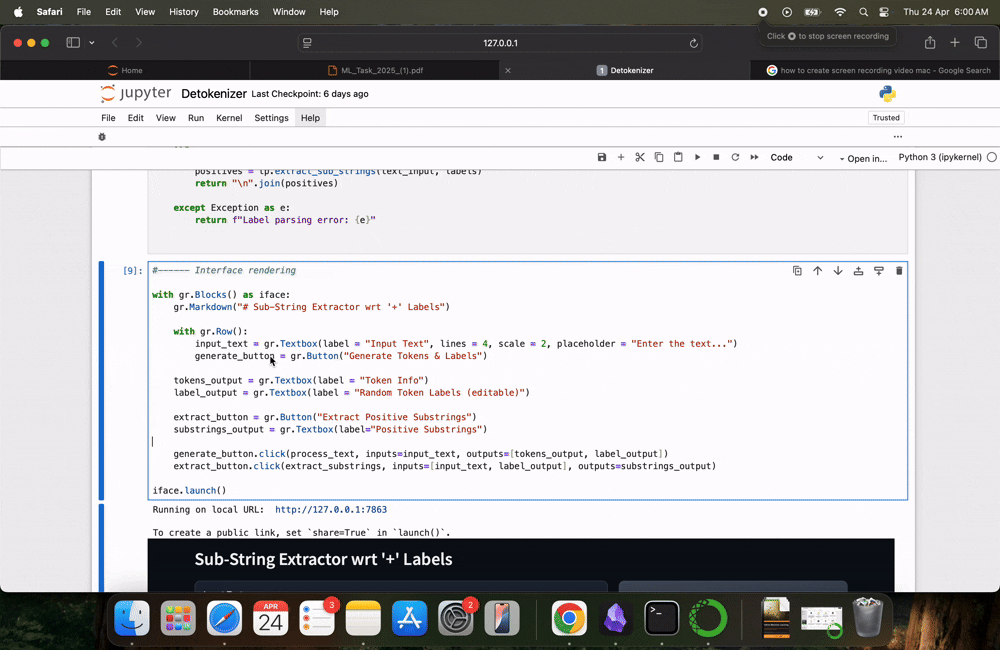